10/07/2017 

A. Gentile
### testing the behaviour of the newly defined "GenSimQMD.py" for both IQLE and QLE

In [1]:
%matplotlib inline

import qinfer as qi
#import qutip as qt
import numpy as np
import scipy as sp
from IPython.display import display, Math, Latex
from functools import partial
import matplotlib.pyplot as plt
import importlib as imp

In [2]:
import datetime
import os as os
import time as time

In [3]:
import logging as logging
import sys

%run LoggingCode.py

In [4]:
# tell the user where files will be saved
dire = os.getcwd()
dire = dire+"/tests/T"
dire = os.path.normpath(dire)
print('Files will be saved in:')
print(dire)

Files will be saved in:
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\QML_share_stateofart\QMD\testing_notebooks\tests\T


In [5]:
# Add personalized library to PYTHONPATH
sys.path.append(os.path.join("..","Libraries","QML_lib"))

In [18]:
from Norms import *
from IOfuncts import *
from EvalLoss import *

import ProbeStates as pros
import multiPGH as mpgh
import GenSimQMD as gsi
import Evo as evo
import Distrib as distr

# Results from trivial step-by-step implementation

In [79]:
imp.reload(pros)
imp.reload(mpgh)
imp.reload(gsi)
imp.reload(evo)
imp.reload(distr)

<module 'Distrib' from '..\\Libraries\\QML_lib\\Distrib.py'>

In [351]:
# Decide the size of the problem

#oplist=np.array([evo.sigmax(), evo.sigmay(), evo.sigmaz()])
oplist=np.array([evo.sigmay(), evo.sigmax()])
# oplist=np.array([evo.sigmaz()])


true_params = np.array([0.3+np.random.rand(len(oplist))/2.5])
print('Chosen true_params: ' + str(true_params))

oplist=np.dot(1.0, oplist)
print('Oplist: ' + repr(oplist))

Chosen true_params: [[ 0.68190198  0.48544651]]
Oplist: array([[[ 0.+0.j,  0.-1.j],
        [ 0.+1.j,  0.+0.j]],

       [[ 0.+0.j,  1.+0.j],
        [ 1.+0.j,  0.+0.j]]])


In [345]:
#Probelist
# probelist = list(map(lambda x: pros.def_randomprobe(oplist), range(15)))
probelist = [pros.choose_probe(oplist)]
print('Chosen probe: ', repr(probelist))


offset = 0.2
prior = distr.MultiVariateUniformDistribution(len(oplist), DistroLimits=np.array([[0.3,0.8]]))

# probelist can be either:
# - [probestate] : in this case the probe is constantly selected from the state provided
# - "eiglist" or "probelist": in this case, the probe is selected sequentially (eventually with some weighting) among the list provided

model = gsi.GenSimQMD(oplist=oplist, modelparams=true_params, probecounter = probecounter,  
                      true_oplist = oplist, trueparams=true_params,
                      probelist=probelist, 
                      trotter = True, IQLE=False)

n_particles = 100
n_experiments = 200

updater = qi.SMCUpdater(model, n_particles, prior, resample_thresh=0.8, resampler = qi.LiuWestResampler(a=0.2), debug_resampling=True)

inv_field = [item[0] for item in model.expparams_dtype[1:] ]
print('Inversion fields are: ' + str(inv_field))
heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
experiment = heuristic()
print('Heuristic output:' + repr(experiment))

expparams = np.empty((1, ), dtype=model.expparams_dtype)

print('Initialization Ready')

Chosen probe:  [array([ 0.85355339+0.35355339j,  0.14644661-0.35355339j])]
Inversion fields are: ['w_1', 'w_2']
Heuristic output:array([(1.871811448299178, 0.3602625806107733, 0.35168934785890443)], 
      dtype=[('t', '<f8'), ('w_1', '<f8'), ('w_2', '<f8')])
Initialization Ready


In [346]:
datum = model.simulate_experiment(true_params, experiment)
print(repr(datum))

1


In [347]:
updater.update(datum, experiment)

In [348]:
# probecounter for the choice of the state
probecounter = 0

track_loss = np.empty(n_experiments)
track_cov = np.empty(n_experiments)
track_time = np.empty(n_experiments)

track_particle_locs = np.empty([n_particles, len(true_params[0]), n_experiments])
track_particle_wght = np.empty([n_particles, n_experiments])


for idx_experiment in range(n_experiments):
    
    experiment = heuristic()
    #print('Chosen experiment: ' + repr(experiment))
    
    if idx_experiment == 0:
        print('Initial time selected > ' + str(experiment[0][0]))
    if idx_experiment == n_experiments-1:
        print('Final time selected > ' + str(experiment[0][0]))
    
    track_time[idx_experiment] = experiment[0][0]
    
    datum = model.simulate_experiment(true_params, experiment)
    #print(repr(datum))
    updater.update(datum, experiment)
#     heuristic = mpgh.multiPGH(updater, oplist, inv_field=inv_field)
    
    track_cov[idx_experiment] = np.linalg.norm(updater.est_covariance_mtx())
    
    track_particle_locs[:, :, idx_experiment] = updater.particle_locations
    track_particle_wght[:, idx_experiment] = updater.particle_weights

    new_eval = updater.est_mean()
    
    new_loss = eval_loss(model, new_eval, true_params)
    track_loss[idx_experiment] = new_loss[0]

qinfer.smc - DEBUG - Resampling changed mean by [ 0.00850477  0.02493793]. Norm change in cov: 0.007760286357505198.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.04844451  0.03799685]. Norm change in cov: 0.0019811409998394115.


Initial time selected > 2.37215304353


qinfer.smc - DEBUG - Resampling changed mean by [-0.01949442 -0.02713236]. Norm change in cov: 0.010430795720371333.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.01445167 -0.00317632]. Norm change in cov: 0.0012517390739527354.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.00562003 -0.00940141]. Norm change in cov: 0.0005380613868863799.
qinfer.smc - DEBUG - Resampling changed mean by [ 0.0139311  -0.00115935]. Norm change in cov: 0.001905052223157759.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00497548  0.00268521]. Norm change in cov: 0.0003400582552622785.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00902575  0.00657365]. Norm change in cov: 0.000585280077541636.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00278981  0.00132882]. Norm change in cov: 0.0007048065775551844.
qinfer.smc - DEBUG - Resampling changed mean by [-0.00559067  0.00233266]. Norm change in cov: 0.0006019905859097012.
qinfer.smc - DEBUG - Resampling changed mean by [-0.0076003

Final time selected > 5.74860312248


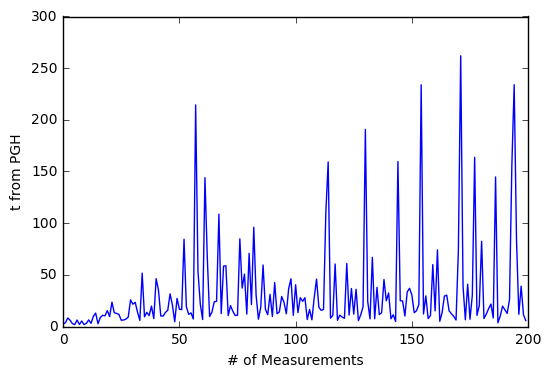

In [349]:
plt.plot(track_time)
plt.xlabel('# of Measurements')
plt.ylabel('t from PGH')

plt.show()

## use this only if real and simulated models coincide

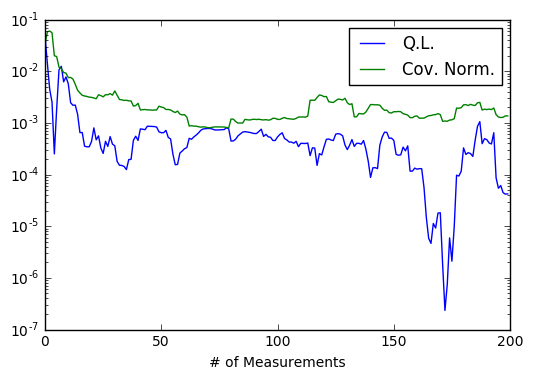

In [350]:
plt.semilogy(track_loss, label='Q.L.')
plt.semilogy(track_cov, label='Cov. Norm.')
plt.legend()
plt.xlabel('# of Measurements')

#plt.savefig(filename)

plt.show()

## use this only for 1D models

## use this only for 2D models

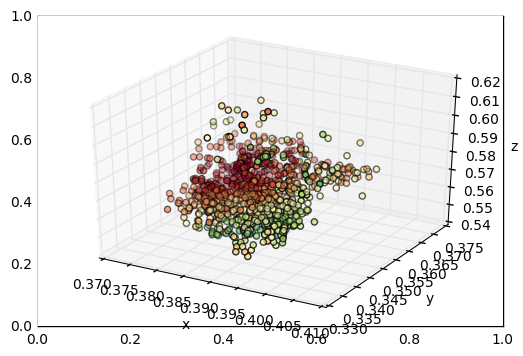

In [118]:
timestep = 175

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.scatter(track_particle_locs[:,0,timestep], track_particle_locs[:,1,timestep],  track_particle_locs[:,2,timestep], c=track_particle_wght[:,timestep], cmap=plt.cm.RdYlGn)
filefigname1 = dire+str(timestamp)+"With_Trotter"+"_Distro_particles"+"_SteNum_"+str(timestep)+"_Npars_"+str(len(true_params[0]))+"_Nexp_"+str(n_experiments)+"_Nparts_"+str(n_particles)+".pdf"
#plt.savefig(filefigname1)
plt.show()